In [ ]:
import ultralytics
import pandas as pd
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

ultralytics.checks()

Ultralytics 8.3.94  Python-3.12.8 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
Setup complete  (16 CPUs, 15.2 GB RAM, 199.6/350.0 GB disk)


In [2]:
model = YOLO('best.pt')

In [ ]:
image_test_path = '583b5745-8755-40ef-94f5-b8c7e766398e.jpg'


image 1/1 d:\VS Code\python\Chess\583b5745-8755-40ef-94f5-b8c7e766398e.jpg: 640x640 1 black-king, 1 black-knight, 3 black-pawns, 1 black-rook, 1 white-bishop, 1 white-king, 1 white-knight, 3 white-pawns, 1 white-queen, 1 white-rook, 141.0ms
Speed: 6.2ms preprocess, 141.0ms inference, 11.8ms postprocess per image at shape (1, 3, 640, 640)


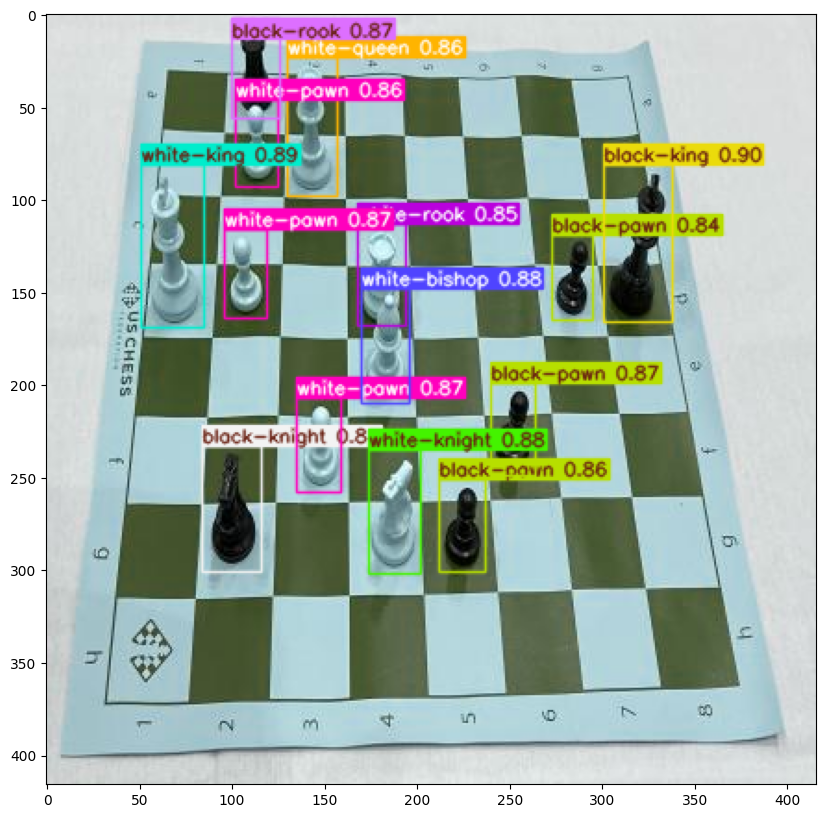

In [ ]:
results = model.predict(source=image_test_path, imgsz=640)

test_image = results[0].plot(line_width=1)
plt.figure(figsize = (10,10))
plt.imshow(test_image)

In [94]:
image_test= cv2.imread(image_test_path)
piceces_location = results[0].boxes.xyxy.cpu().numpy()
piceces_label = results[0].boxes.cls.cpu().numpy()
piceces_label_names = results[0].names
piceces_conf = results[0].boxes.conf.cpu().numpy()
piceces_info= pd.DataFrame( columns=['piece_name', 'piece_center_loc'])
for i in range(len(piceces_label)):
    if piceces_conf[i] > 0.5:
        piceces_info.loc[i, 'piece_name'] = piceces_label_names[int(piceces_label[i])]
        center_x = (piceces_location[i][0] + piceces_location[i][2]) / 2
        center_y = ((piceces_location[i][1] + piceces_location[i][3]) / 2)+ 0.25 * (piceces_location[i][3] - piceces_location[i][1])
        piceces_info.loc[i, 'piece_center_loc'] = (center_x, center_y)

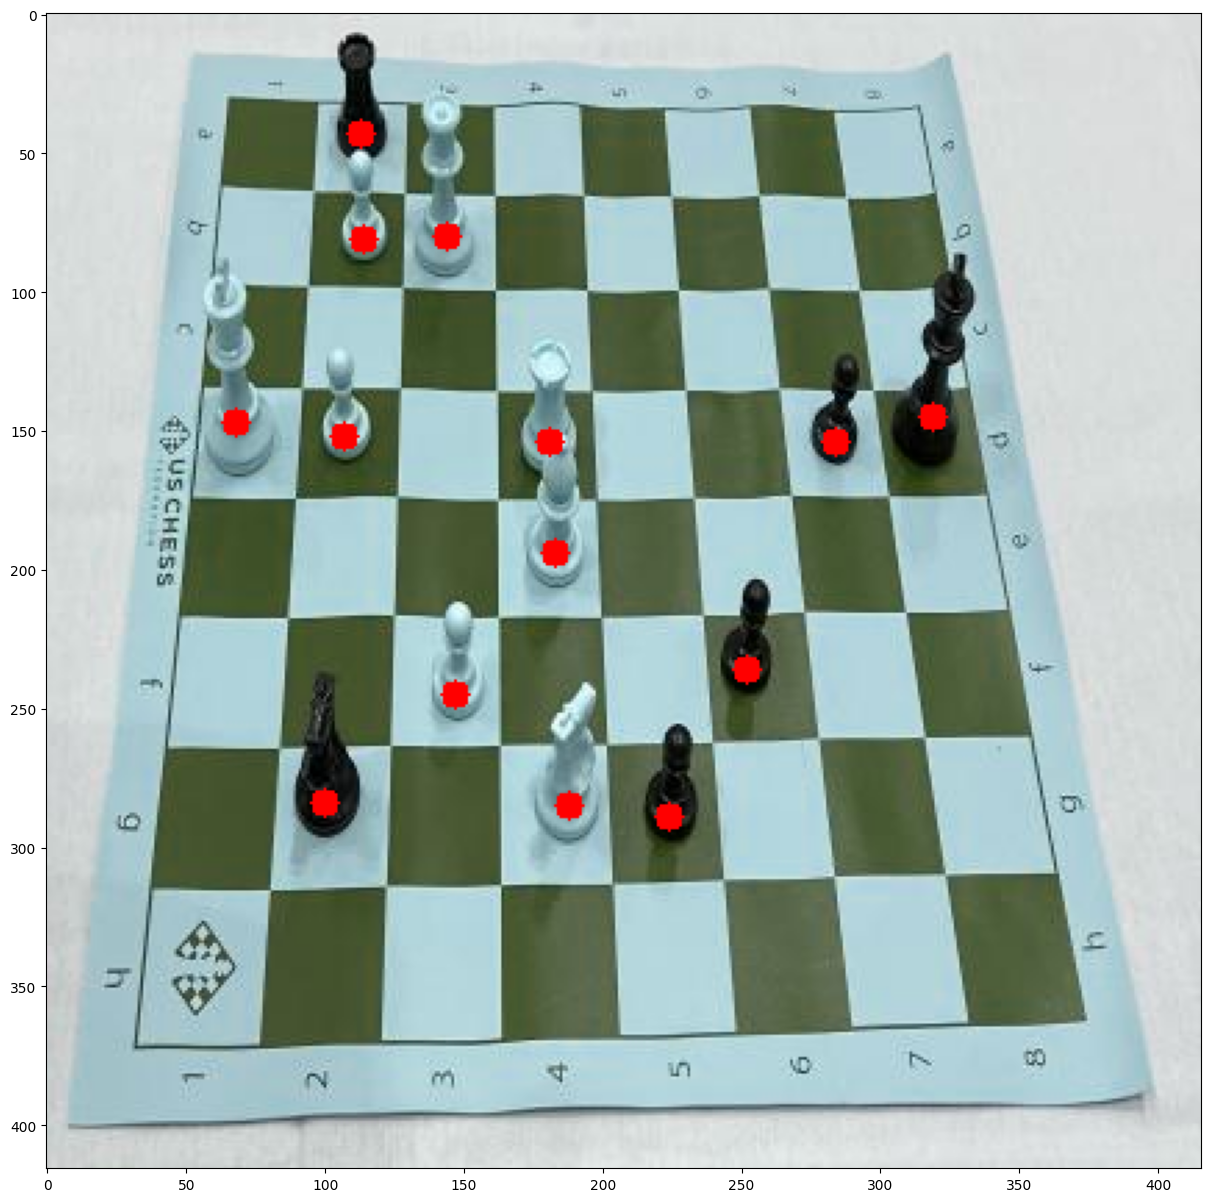

In [ ]:
for i in range(len(piceces_info)):
    center = piceces_info['piece_center_loc'][i]
    cv2.circle(image_test, (int(center[0]), int(center[1])), 5, (255, 0, 0), -1)
plt.figure(figsize = (15,15))
plt.imshow(image_test)

In [96]:
piceces_info

,piece_name,piece_center_loc
0,black-king,"(319.93237, 145.27003)"
1,white-king,"(68.64357, 147.35916)"
2,white-bishop,"(183.59686, 194.7796)"
3,white-knight,"(188.42125, 285.86285)"
4,black-pawn,"(252.46405, 236.91849)"
5,white-pawn,"(147.67833, 245.67072)"
6,black-rook,"(113.56484, 43.316944)"
7,white-pawn,"(107.93948, 152.57002)"
8,black-pawn,"(224.89734, 289.2043)"
9,white-pawn,"(114.13493, 81.60353)"


In [ ]:
def warp_full_board_from_inner_grid(image_path, pattern_size=(7, 7), board_size=800):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCornersSB(gray, pattern_size)

    if not ret:
        raise Exception("Could not find chessboard corners.")

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    square_size = board_size / 8
    obj_pts = []
    for i in range(pattern_size[1]):
        for j in range(pattern_size[0]):
            obj_pts.append([ (j + 1) * square_size, (i + 1) * square_size ])
    obj_pts = np.array(obj_pts, dtype=np.float32)

    H, _ = cv2.findHomography(corners.reshape(-1, 2), obj_pts)
    warped = cv2.warpPerspective(image, H, (board_size, board_size))

    return warped, H

def find_square(image_path, x, y):
    warped, H = warp_full_board_from_inner_grid(image_path)
    pt = np.array([[[x, y]]], dtype=np.float32)
    warped_pt = cv2.perspectiveTransform(pt, H)
    wx, wy = warped_pt[0][0]
    wx = max(0, min(wx, warped.shape[1] - 1))
    wy = max(0, min(wy, warped.shape[0] - 1))

    square_size = warped.shape[0] / 8 

    col = int(np.floor(wx / square_size))
    row = int(np.floor(wy / square_size))
    col = max(0, min(col, 7))
    row = max(0, min(row, 7))

    col_letter = chr(ord('a') + col)
    row_number = 8 - row

    return f"{col_letter}{row_number}"


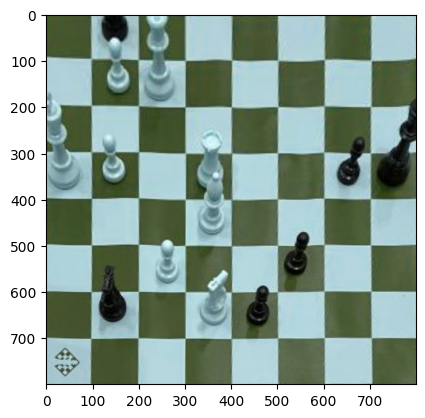

In [ ]:
for i in range(len(piceces_info)):
    center = piceces_info['piece_center_loc'][i]
    square = find_square(image_test_path, center[0], center[1])
    piceces_info.loc[i, 'piece_square'] = square

In [99]:
piceces_info

,piece_name,piece_center_loc,piece_square
0,black-king,"(319.93237, 145.27003)",h5
1,white-king,"(68.64357, 147.35916)",a5
2,white-bishop,"(183.59686, 194.7796)",d4
3,white-knight,"(188.42125, 285.86285)",d2
4,black-pawn,"(252.46405, 236.91849)",f3
5,white-pawn,"(147.67833, 245.67072)",c3
6,black-rook,"(113.56484, 43.316944)",b8
7,white-pawn,"(107.93948, 152.57002)",b5
8,black-pawn,"(224.89734, 289.2043)",e2
9,white-pawn,"(114.13493, 81.60353)",b7
